## Initial Setup

Some of these imports access modules from the Geoscience datacube and modules that have been written specifically for this notebook, which are contained in the Scripts folder. Run these imports and subsequent cells by pressing 'Shift' + 'Enter'. There is a tab called Kernel in the top left of the Sandbox. If you want to clear all the outputs and re-set the notebook, select 'Restart Kernal and Clear All Outputs'.

In [1]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import sys
sys.path.append('../Scripts')
import os
import pickle

from datacube.helpers import write_geotiff

from pathlib import Path
import dea_bom
import pandas as pd
import numpy as np
import xarray as xr
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

## List of All Available Stations

This part of the code accesses the dea_bom.py module which contains an XML webscraping code. It retrieves the stream gauges from BOM's Water Data Online website.

In [2]:
%%time
stations_pkl = Path('stations.pkl')

# if cache exists, get it from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))
    
len(stations), stations[:5]

Loading from cache
CPU times: user 4.6 ms, sys: 8.02 ms, total: 12.6 ms
Wall time: 10.7 ms


(6027,
 [namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
  namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
  namespace(name='15 MILE CK GLENROWAN', pos=(-36.47080718, 146.246199), url='http://bom.gov.au/waterdata/services/stations/403251'),
  namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
  namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318')])

## Plot a map of stations and select a gauge that contains data

Running this cell will generate a map displaying the locations of stream gauges in Australia. It will take about 20 seconds to load. Choose a gauge on the map by clicking on it. Note that after you click on a gauge it can take a second or two to respond. Also note that a few gauges have no data available and will retrieve zero observations, so you will have to click around until you find a gauge with good data. When you have the station you want, you must click the Done button before moving onto the next box. If you want to choose a different gauge after having pressed the Done button, you must re-run this box to regenerate the map then choose another gauge and press Done again. 

In [4]:
gauge_data, station = dea_bom.ui_select_station(stations);

## Generate a flow duration curve from the data selected above
The code in the box below will automatically select the latitude and longitude of the selected gauge, but you can enter a different lat and lon if you want by following the hashtag lines in the code below. The output will tell you what lat and lon has been selected. The buffer, which is the radius around the location point, is set to 8000 meters but you can change it if you like.

You have selected: lat = -36.01760591
You have selected: lon = 144.9610344


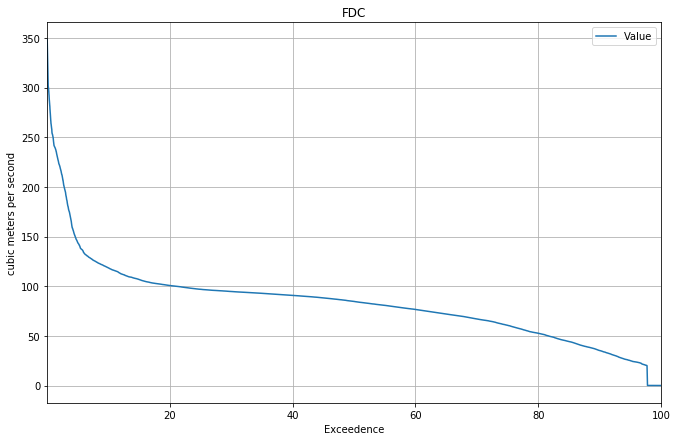

In [5]:
pos = station.pos

#The lat and lon takes the location of the gauge (pos). You can change the lat and lon to a different location if necessary, 
#just hashtag out this lat, lon = pos line below and define your own.
lat, lon = pos

#lat =
#lon = 

#The buffer is how many meters radius around the location you want to display.
buffer = 8000 

#Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100

#Plotting the flow duration curve
gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('cubic meters per second')
plt.grid(True)
plt.title('FDC')

print("You have selected: lat = {}".format(lat))
print("You have selected: lon = {}".format(lon))

## Enter the y-axis parameters in cubic meters per second then run the cell with 'Shift' + 'Enter'

In [6]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 125
yaxis_higher_parameter = 350

This next box plots your selection on a log of the FDC so you can see what part of the FDC you selected on a log scale. This is also the section which calls the satellite data from the Geoscience datacube. You will note that the query contains time, which you can change to any time frame you like using the format "yyyy-mm-dd" on the line that says # You can change this date accordingly. The output will also tell you how many passes were called from the datacube that will then be loaded in the next section. 

You are about to load this many satellite passes: 70


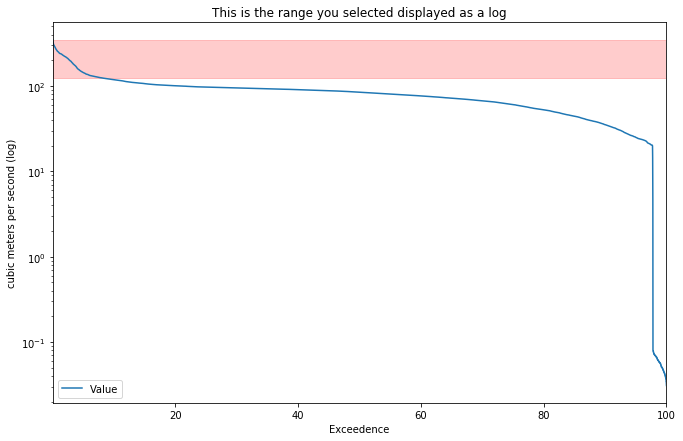

In [7]:
#Let's look at it on a log scale
ax2 = gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7)) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This is the range you selected displayed as a log')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

gauge_data_xr = gauge_data.to_xarray()

#Dask loading wofs_albers data (loading parameters only, not loading the actual satellite data since 1988)
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-10-01'), # You can change this date accordingly
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

# Merging satellite data with gauge data by timestamp
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

print("You are about to load this many satellite passes: {}".format(specified_level.time.shape[0]))


The box below will cloud mask the images, meaning it will take out images that had too much cloud to see anything. It will then generate a summary image made by layering the clear images on top of each other to show the frequency of water observed while the gauge was reading the specified flow values. Yellow means water was present in every pass during the specified flows and purple means it was there 20% of the time or less. The output will also tell you how many clear passes were used to generate the image.

This image was made by layering this many images: 59


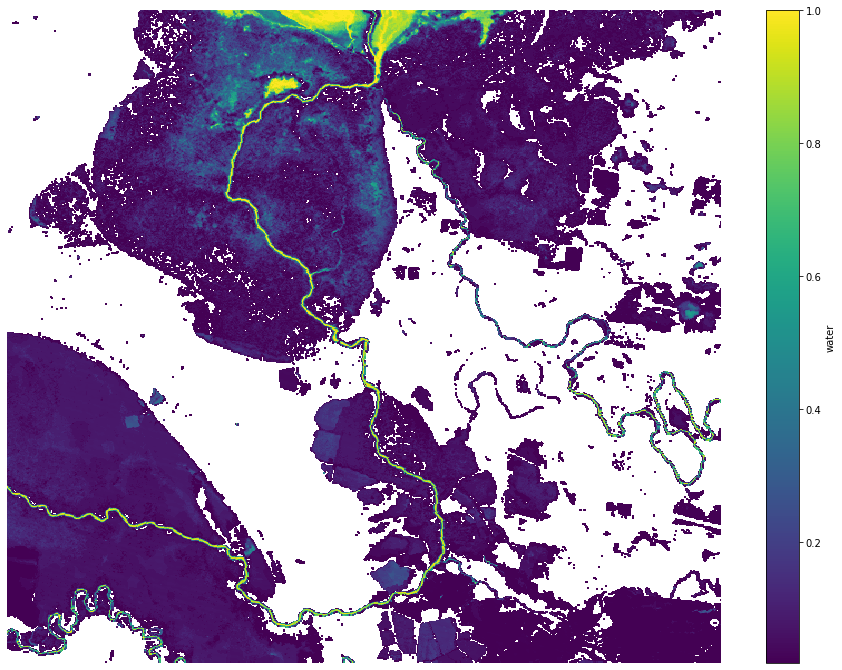

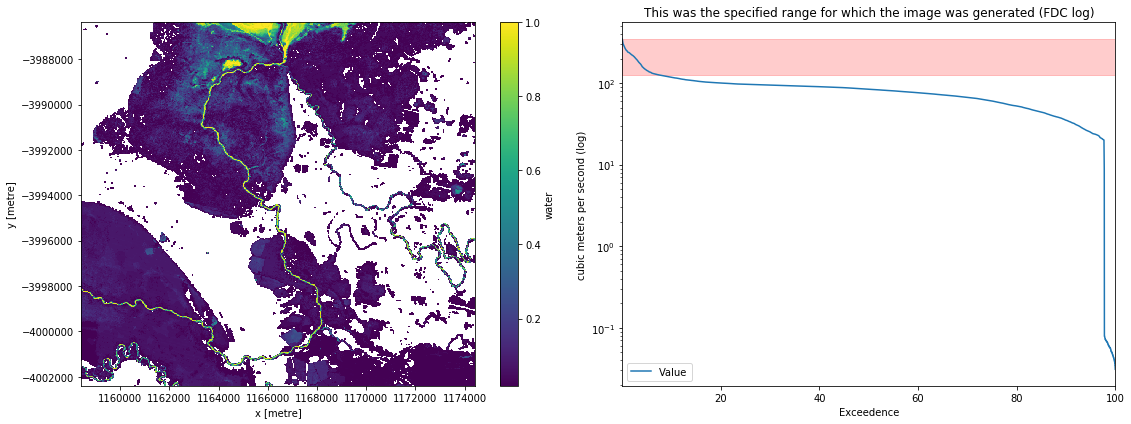

In [8]:
# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# prune out "too cloudy" passes
cc = masking.make_mask(specified_passes.water, cloud=True)

npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice

ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)

clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.5)
clear_specified_passes.shape

#Create parameters for the image
wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated (FDC log)')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

plt.tight_layout()

print("This image was made by layering this many images: {}".format(clear_specified_passes.time.shape[0]))

Great, this is an image of the gauge location according to the flow values you selected. You can now go back and change the flow parameters or you can re-run the map box and choose a different gauge all together. Would you like to see a list of dates that were used to make this summary image? If yes, run the box below. 

In [9]:
clear_specified_passes.time

<xarray.DataArray 'time' (time: 59)>
array(['1988-06-21T23:39:50.500000000', '1988-08-08T23:39:56.500000000',
       '1990-11-02T23:28:38.500000000', '1990-11-18T23:28:41.000000000',
       '1992-10-22T23:30:40.500000000', '1992-11-23T23:30:14.500000000',
       '1992-12-09T23:30:28.500000000', '1992-12-25T23:30:38.500000000',
       '1993-01-10T23:30:49.500000000', '1993-07-21T23:31:37.500000000',
       '1993-08-22T23:31:36.500000000', '1993-09-23T23:31:32.500000000',
       '1993-10-25T23:31:21.500000000', '1993-11-10T23:31:13.500000000',
       '1993-11-26T23:31:07.500000000', '1995-08-12T23:12:46.500000000',
       '1995-08-28T23:12:01.500000000', '1995-11-16T23:08:44.500000000',
       '1996-08-30T23:26:06.500000000', '1996-09-15T23:26:59.500000000',
       '1996-10-17T23:28:40.500000000', '1996-11-18T23:30:11.500000000',
       '1998-10-07T23:48:04.000000000', '1998-10-23T23:48:04.500000000',
       '1999-09-17T00:02:03.500000000', '2000-10-04T23:59:38.500000000',
       '2000-1

## Save the file as a geotiff
You might want to use this image in another workflow, so here is some code that will save it as a .tif file for you. Enter a name for the .tif file below. The ../ part of the name means it will save this file one directory up from where this notebook is saved, ie in your dea-notebooks folder. 

In [10]:
file_name = '../file_name_here.tif'

In [11]:
frequency_dataset = frequency.to_dataset()
frequency_dataset.attrs=wofs_albers.attrs
# Write geotiff to a location
write_geotiff(file_name, frequency_dataset)